# Hello World Graph

In [1]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph

In [2]:
class AgentState(TypedDict): # State Schema
    message : str


def greeting_node(state: AgentState) -> AgentState:
    """Simple node that adds a greeting message to the state"""

    state['message'] = "Hey" + state["message"] + ", how is your day going?"

    return state

In [3]:
graph = StateGraph(state_schema=AgentState)

graph.add_node("greeter", greeting_node)

graph.set_entry_point("greeter")
graph.set_finish_point("greeter")

app = graph.compile()

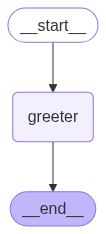

In [4]:
from IPython.display import Image, display
display(Image((app.get_graph().draw_mermaid_png())))

In [5]:
result = app.invoke({"message" : "Bob"})

In [6]:
result["message"]

'HeyBob, how is your day going?'

# Graph with multiple inputs

In [7]:
from typing import TypedDict, List
from langgraph.graph import StateGraph

In [8]:
class AgentState(TypedDict):
    values: List[int]
    name: str
    result: str

In [9]:
def process_values(state: AgentState) -> AgentState:
    """This function handles multiple different inputs"""
    state["result"] = f"Hi there {state['name']}! Your sum = {sum(state['values'])}"
    return state

In [10]:
graph = StateGraph(state_schema=AgentState)

graph.add_node("processor", process_values)
graph.set_entry_point("processor")
graph.set_finish_point("processor")

app = graph.compile()

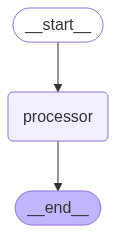

In [11]:
from IPython.display import Image, display
display(Image((app.get_graph().draw_mermaid_png())))

In [12]:
result = app.invoke({"values": [1, 2, 3, 4], "name":"Steve"})

In [13]:
result

{'values': [1, 2, 3, 4],
 'name': 'Steve',
 'result': 'Hi there Steve! Your sum = 10'}

# Sequential Graph

In [14]:
from typing import TypedDict
from langgraph.graph import StateGraph

In [15]:
class AgentState(TypedDict):
    name: str
    age: str
    final: str

In [16]:
def first_node(state: AgentState) -> AgentState:
    """This is the first node of our Sequence"""
    state['final'] = f"Hi, {state['name']}!"
    return state    

def second_node(state: AgentState) -> AgentState:
    """This is the second node of our Sequence"""
    state['final'] += f" You are {state['age']} years old!"
    return state    
    


In [17]:
graph = StateGraph(AgentState)

graph.add_node("first_node", first_node)
graph.add_node("second_node", second_node)

graph.set_entry_point("first_node")
graph.add_edge('first_node', 'second_node')
graph.set_finish_point("second_node")

app = graph.compile()

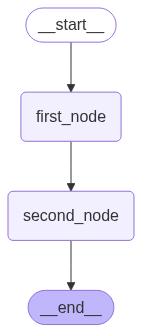

In [18]:
from IPython.display import Image, display
display(Image((app.get_graph().draw_mermaid_png())))

In [19]:
result = app.invoke({"name": "Charlie", "age": "20"})
print(result)

{'name': 'Charlie', 'age': '20', 'final': 'Hi, Charlie! You are 20 years old!'}


# Conditional Graph

In [20]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

In [21]:
class AgentState(TypedDict):
    number1: int
    operation: str
    number2: int
    final: int

In [22]:
def adder(state: AgentState)-> AgentState:
    """This node adds the two numbers"""
    state['final'] = state['number1'] + state['number2']
    return state

def subtractor(state: AgentState)-> AgentState:
    """This node subtracts the two numbers"""
    state['final'] = state['number1'] - state['number2']
    return state

def decide_next_node(state: AgentState) -> AgentState:
    """This Node selects the next node of the graph"""
    if(state['operation'] =='+'):
        return "addition_operation"
    else:
        return "subtraction_operation"


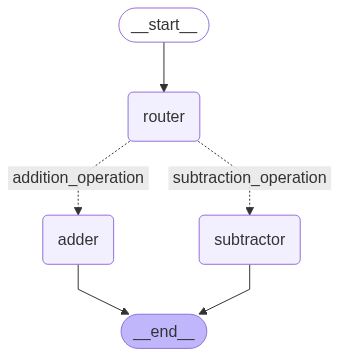

In [23]:
graph = StateGraph(AgentState)

graph.add_node("adder", adder)
graph.add_node("subtractor", subtractor)
graph.add_node("router", lambda state:state)

graph.add_edge(START, "router")

graph.add_conditional_edges(
    "router",
    decide_next_node,
    {
        "addition_operation" : "adder",
        "subtraction_operation" : "subtractor",
    },
)

graph.add_edge("adder", END)
graph.add_edge("subtractor", END)

app = graph.compile()
app 

In [24]:
app.invoke({
    "number1" : 10,
    "operation" : "-",
    "number2" : 100
})

{'number1': 10, 'operation': '-', 'number2': 100, 'final': -90}

# Looping Graph


In [25]:
from langgraph.graph import StateGraph, END
from typing import Dict, TypedDict, List
import random

In [26]:
class AgentState(TypedDict):
    name: str
    numbers: List[int]
    counter: int

In [27]:
def greeting_node(state: AgentState) -> AgentState:
    """Greeting node that says hi to the user"""
    state["name"] = f"Hi there, {state['name']}"
    state["counter"] = 0
    
    return state

In [28]:
def random_node(state: AgentState) -> AgentState:
    """Generates a random number from 0 to 10"""

    state["numbers"].append(random.randint(0, 10))
    state["counter"] += 1
    return state

In [ ]:
def should_continue(state: AgentState) -> str:
    """Function to decide whether the loop should continue or break"""
    if(state['counter'] < 5):
        return "loop"
    else:
        return "exit"

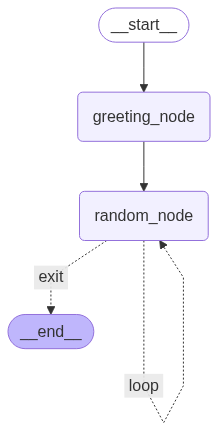

In [31]:
graph = StateGraph(state_schema=AgentState)

graph.add_node("greeting_node", greeting_node)
graph.add_node("random_node", random_node)
graph.add_edge("greeting_node", "random_node")
graph.add_conditional_edges(
    "random_node",
    should_continue,
    {
        "loop" : "random_node",
        "exit": END
    }
)

graph.set_entry_point("greeting_node")

app = graph.compile()
app

In [33]:
app.invoke({"name": "Chris", "numbers":[], "counter":-1})

{'name': 'Hi there, Chris', 'numbers': [4, 1, 1, 9, 5], 'counter': 5}